# Bayesian Inference of Enzyme Kinetics - Complex example

This notebook will show how measurements on enzymatic systems with partial observability can be used to perform Bayesian Inference in order to estimate kinetic parameters.
This requires the usage of a custom Theano operator that implements the numeric calculation of steady-state concentrations directly from the system of ODE's, alongside with gradient information in order to use Hamiltonian Monte Carlo sampling.

This notebook uses the same dataset of R-AMC cleavage to AMC by the enzyme Trypsin, and inhibited by AAA-AMC, but implement the steady-state condition via a Theano operator instead of explicitly.




In [1]:
# Standard scientific imports
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.optimize as optimize
import sympy as sp

# Bayesian inference imports
import pymc3 as pm
import arviz as az
import theano.tensor as tt

# Visualization imports
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns; sns.set_theme(style='ticks', context='notebook', font_scale=0.8);

# Package with the SteadyStateOperator
from bayern import ops
# function to speed up numerical computations
from numba import njit

%reload_ext watermark
%watermark -a "Mathieu Baltussen" -d -t -u -v -iv

Author: Mathieu Baltussen

Last updated: 2022-04-11 14:28:39

Python implementation: CPython
Python version       : 3.9.5
IPython version      : 8.2.0

numpy     : 1.20.3
arviz     : 0.11.4
theano    : 1.1.2
matplotlib: 3.4.3
sympy     : 1.8
bayern    : 0.1.0
scipy     : 1.6.3
pandas    : 1.2.4
seaborn   : 0.11.2
pymc3     : 3.11.4



## Data import

In [2]:
data = pd.read_csv("../data/CEKS33.csv")
kf = 0.125  # minute^-1
E = 0.012 
data = data.assign(kf=kf, Tr=E)
data

,R,AAA,AMC,kf,Tr
0,50,0,2.609888,0.125,0.012
1,100,0,4.265064,0.125,0.012
2,200,0,6.197783,0.125,0.012
3,300,0,7.167780,0.125,0.012
4,500,0,7.681850,0.125,0.012
5,50,1500,2.501800,0.125,0.012
6,100,1500,3.882780,0.125,0.012
7,200,1500,5.150944,0.125,0.012
8,300,1500,5.629337,0.125,0.012
9,500,1500,5.961178,0.125,0.012


## Model definition

Similar to the model found in `example_simple.ipynb`, the system is described by a set of ODE's.

$$
\mathbf{f}(\mathbf{x}, \phi, \theta): \begin{cases}
\frac{dS}{dt} &= \frac{-k_{cat}ES}{K_M + S*(1+I/K_I)} + k_f\cdot (S_{in} - S)\\
\frac{dP}{dt} &= \frac{k_{cat}ES}{K_M + S*(1+I/K_I)} - k_f\cdot P 
\end{cases}
$$

with state variables $\mathbf{x} = [S, P]$, kinetic parameters $\phi = [k_{cat}, K_M, K_I]$, and control parameters $\theta = [S_{in}, I, k_f, E]$.

These equations are implemented symbolically using the SymPy package. 
SymPy is then used to determine the symbolic expressions for the Jacobians ($J_i$) with respect to the state variables $\mathbf{x}$, the kinetic parameters $\phi$, and the control parameters $\theta$.
These equations, together with the rate equation $\mathbf{f}$ are converted to their numeric counterpart, and wrapped inside a `numba-njit` wrapper, which speeds up their computation by applying optimization algorithms.
Using these functions, the gradient of the steady-state conditions $\frac{dg}{d\phi}$ is determined using the Implicit Function Theorem:
$$
\frac{dg}{d\phi}(\phi, \theta)= - J_x^{-1}\cdot J_\phi
$$
which can be directly calculated from the numeric Jacobians.

Finally, an algorithm is determined to efficiently calculate the steady-state conditions directly from the set of rate equations $\mathbf{f}$. 
This can be done either via direct integration over a long time, or by finding the root of the function $\mathbf{f}$. 
However, while the latter method is faster, it may be less reliable in more complex systems.

In [3]:
R, AMC = sym_x = sp.symbols("R, AMC") # State variables
k_cat, K_M, K_I = sym_phi = sp.symbols("k_cat, K_M, K_I") # Kinetic parameters
R_in, AAA_in, kf, Tr = sym_theta = sp.symbols("R_in, AAA_in, kf, Tr ")  # Control parameters

# Rate equation
sym_rate_equations = [
    -k_cat * Tr * R / (K_M + R * (1+AAA_in/K_I)) + kf*(R_in - R),
    k_cat * Tr * R / (K_M + R * (1+AAA_in/K_I)) - kf*AMC
]

# The Jacobians
sym_jac_x = sp.Matrix(sym_rate_equations).jacobian(sym_x)
sym_jac_phi = sp.Matrix(sym_rate_equations).jacobian(sym_phi)
sym_jac_theta = sp.Matrix(sym_rate_equations).jacobian(sym_theta)

# Numeric equations
num_rate_equations = njit(sp.lambdify([sym_x, sym_phi, sym_theta], sym_rate_equations, "numpy"))
num_jac_x = njit(sp.lambdify([sym_x, sym_phi, sym_theta], sym_jac_x, "numpy"))
num_jac_phi = njit(sp.lambdify([sym_x, sym_phi, sym_theta], sym_jac_phi, "numpy"))
num_jac_theta = njit(sp.lambdify([sym_x, sym_phi, sym_theta], sym_jac_theta, "numpy"))

# Numeric gradients (theta is currently unused, but still has to be given to the operator)
num_grad_phi = njit(lambda x,phi,theta: np.dot(-np.linalg.inv(num_jac_x(x,phi,theta)),num_jac_phi(x,phi,theta)))
num_grad_theta = njit(lambda x,phi,theta: np.dot(-np.linalg.inv(num_jac_x(x,phi,theta)),num_jac_theta(x,phi,theta)))

# Function to numerically determine the steady-state concentrations
def find_root(fun, jac, phi, theta):
    return optimize.root(fun=fun, x0=[theta[0],0.0], jac=jac, args=(phi, theta)).x


With the numerical expressions for the steady-state concentrations, jacobians, and gradients, we can again construct a probabilistic model using PyMC3.
However, now instead of explicitly writing down the steady-state condition, we create an operator (the SteadyStateOp) from the various numerical expressions combined with a matrix containing the control parameters for every observations.
This `theta_set` matrix is obtained from the Pandas dataframe holding all data.

The SteadyStateOp takes a stacked tensor of the kinetic parameters that need to be inferred, and returns the predicted steady-state concentrations for every observation associated to the set of theta-values.
As we only observe the product concentration, we only use the second component returned by the operator to feed into the final likelihood calculation.

This probabilistic model can be sampled in the same way as an explicitly defined model, and as expected returns the same results.
The posterior obtained from the sampling can be analysed exactly in the same way as well.
However, due to explicit numerical calculation of steady-state concentrations and gradients, the process is normally much slower then an explicitly defined model.
Thus, when partial observability is not an issue, and when the steady-state condition can be written down explicitly, using the operator is not encouraged.


In [4]:
with pm.Model() as model:
    # Stating the priors
    k_cat = pm.Uniform("k_cat", 0, 500)
    K_M = pm.Uniform("K_M", 0, 500)
    K_I = pm.Uniform("K_I", 1000, 10000)
    phi_set = tt.stack([k_cat, K_M, K_I])
    
    sigma = pm.Exponential("sigma", 10)

    # We extract all data from the dataframe here so the likelihood is easier to write down
    P_obs = data["AMC"].values

    theta_set = data[["R", "AAA", "kf", "Tr"]].values
    SteadyStateOp = ops.SteadyStateDatasetOp(num_rate_equations, num_jac_x, num_grad_phi, num_grad_theta, find_root, theta_set=theta_set)

    # Inference of probabilistic model at steady-state conditions
    P = pm.Normal(
        "obs", 
        mu=SteadyStateOp(phi_set)[:,1], 
        sigma=sigma, 
        observed=P_obs
    )

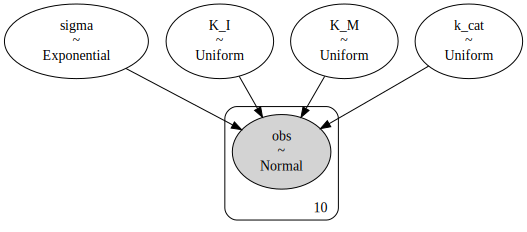

In [5]:
pm.model_to_graphviz(model)

In [6]:
with model:
    idata = pm.sample(
        1000,
        tune=1000,
        cores=8,
        step=pm.NUTS(target_accept=0.95),
        return_inferencedata=True,
    )

Multiprocess sampling (8 chains in 8 jobs)
NUTS: [sigma, K_I, K_M, k_cat]


Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 24 seconds.


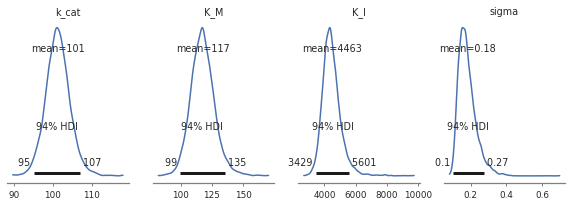

In [7]:
with model:
    az.plot_posterior(idata, figsize=(10,3))